In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import sklearn

# What we know:

#### The kaggle provided dataset contains 3 files:  
##### comment_to_score.csv
    - Contains all unranked comments. Our objective is to rank these comments based off the toxicity, with 1 being the most toxic. 

##### sample_submission.csv
    - Contains an example of how the submission should look like... Not sure if this will help with training?

##### validation_data.csv
    - According to kaggle this is the "pair rankings that can be used to validate models. Includes annotator work id and how the annotator ranked a given pair of comments"
    
# Understanding the objective
Before moving on, let's take a moment and understand what our overall objective is: 
We want to rank a list of comments base off of the level of toxicity without the use of any provided training data. However, while we do not have training data, we have provided validation data, which includes a set of toxicity rankings that might help to validate models.

# Understanding our data:
In the next few lines, we will import our data and see what we're actually dealing with and see if the data provided is actually useful. 

#### comments_to_score.csv
        - We knew how the data looked like before, but let's take a closer look and see what might need to be cleaned up  
   
   - Column Names
       - comment_id (comment identifier)
       - text (actual text)

In [2]:
# comments_to_score data
df = pd.read_csv("./data/comments_to_score.csv")
eg1 = df.text[0]
print(eg1)

"
 

Gjalexei, you asked about whether there is an ""anti-editorializing"" policy here.  There is, and it's called wikipedia:neutral point of view.  It discusses at some length  the case of what we should do when writing about a subject which most of us find repugnant.  Whilst you're not likely to get too many defenders of FGM here, the need for the policy should be clearer for articles like abortion, for instance.

If something you write is edited and you're not sure why, please continue to question such edits on the talk page.  Sometimes, you'll learn more about wikipedia policy.  Sometimes, you'll find out that some other people working on here can get it flat-out wrong ) Robert Merkel"


In [3]:
eg2 = df.text[25]
print(eg2)

"

I already gave you the source for all my edits   The Slur database, so I will not continue to play your little game. If you weren't so lazy and intent on harassment, you could use Google to search for ""Gargamel"" and ""Jew"". You get more than 400 hits including white supremacist sites and an academic paper dating to 1996. It's obviously a real slur with some usage. Nice try at being obdurate though. I'm sure there's a slur that describes that characteristic. Shyster doesn't quite cover it.  22:08, 22 Dec 2004 (UTC)"


##### took two comments from the provided dataset. We can make a few observations based off of the content of the texts:   
  
- First, punctuation. Normally, when we deal with datasets that involve texts, we would ignore punctuation. Howevever, knowing the habits of the internet, the punctuation can reflect toxicity. For instance, quotation marks have been used to represent sarcasm.
    -Building onto this, this same concept applies with capitalized letters. Generally speaking, when dealing with texts, we would try to make the letters consistent. However, given the habits of the internet, we can 
    
- I believe we can consider the second comment to be more toxic. But let's try to understand what makes it toxic: 
    - "If you weren't so lazy and intent on harassment, you could use Google to search for ""Gargamel"" and ""Jew""". 
        - This particular sentence feels targeted, with lazy being the negative description.   
        - Might want to consider pulling common words, phrases, and general patterns with the provided validation dataset as a means to start. However, keep in mind that the dataset also contains data that is not in our testing set

###### Validation_data.csv
After playing around with the data, I've come to realize the order of the comments do not matter. As described on Kaggle, this ia a collection of comments, which a person judged a pair of comments to see which one is more or less toxic (making almost binary). The comments are kinda hilarious from a third person perspective.  
  
Looking at the data on excel, I noticed that some comments are repeated, showing that it's been consistently rated as being more toxic than the other. It might be interesting to make a histogram based off of the number times a comment is rated as toxic. We can also create a list of toxic comments and have it ordered from most toxic to least toxic based off the number of counts it was rated as more toxic. 

In [4]:
vd = pd.read_csv("./data/validation_data.csv")
eg3 = vd.loc[0,:]
eg3

worker                                                      313
less_toxic              This article sucks \n\nwoo woo wooooooo
more_toxic    WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
Name: 0, dtype: object

In [5]:
eg4 = vd.loc[100,:]
eg4

worker                                                       46
less_toxic                           I'm Jim,a retarded idiot .
more_toxic     You are a nazi. \n\nYour defense of the Latin...
Name: 100, dtype: object

##### sample_submission.csv
This simply tells us how we should make our submission, it is interesting that we only care about the comment_id and the score. Although I am more interested in how the score will be developed. Is it unique or what?

In [6]:
eg5 = pd.read_csv("./data/sample_submission.csv")
eg5.loc[0:5,:]

,comment_id,score
0,114890,0.5
1,732895,0.5
2,1139051,0.5
3,1434512,0.5
4,2084821,0.5
5,2452675,0.5


### Testing out Ideas

In the previous section, I discussed ideas to explore. In this section, we will try out those ideas and see how they could apply to our model. 

In [7]:
## Find all the unique comments in the validation dataset. 

# Alright, so I want to look at this data with ease. To save time and memory, I'm going to give each unique comment a unique number
# And count the number of occurences the unique ID has. 
toxic_unique = vd.more_toxic.unique()
toxic_dict = {};
not_toxic_unique = vd.less_toxic.unique()
not_toxic_dict = {};
count = 0;

for tword in toxic_unique:
    toxic_dict[count] = [tword, len(vd.index[vd.more_toxic == tword].tolist())]
    count += 1
    # Create a dictionary that we can use
    #I don't know how much time or memory this uses, but basicaly I am creating a dictionary which stores the number of counts per unique comment

count = 0
for ntword in not_toxic_unique:
    not_toxic_dict[count] = [ntword, len(vd.index[vd.less_toxic == ntword].tolist())] # Create a dictionary that we can use
    count +=1

In [8]:
toxic_df = pd.DataFrame.from_dict(toxic_dict, orient = 'index', columns = ['text', 'count']).sort_values(by =['count'], ascending = False)
not_toxic_df = pd.DataFrame.from_dict(not_toxic_dict, orient = 'index', columns = ['text', 'count']).sort_values(by = ['count'], ascending = False)

toxic_df[0:20]

,text,count
3603,YOU SUCK \n\nI HATE YOU> YOU CAN FUCK MY ASS ...,14
905,STUPID SPANISH CENTRALISTSTUPID SPANISH CENTRA...,14
788,MORON! The USA has only 5% of the worlds popul...,12
1247,"LAST WARNING YOU FUCKING TOSSER, IT TAKES ME 1...",12
1990,Imma cut off ur nutz and send em to ur gf \n\...,12
1516,PEOPLE ON THIS SITE SUCK \n\nPEOPLE ON THIS ...,12
4523,"""\n\nBastard Child\nDoes anyone know if Obama ...",12
2130,INTEVIEW \n\nME: ARE YOU GAY?\n\nABE GAY DASH...,12
563,YOU'RE A FUCKING LIAR WHO DOESN'T KNOW HOW TO ...,12
695,ScJessey is a Big Fat Faggot Pinko Commie Asshole,12


In [9]:
not_toxic_df[0:20]

,text,count
5422,How many sockpuppets do you have?,13
786,sorry i jumped to conclusions \n\non christia...,13
2192,"Sockpuppet\nHi, would you please confirm this ...",12
4930,I erased your cuss word\nFrom: some random per...,12
4021,An addition comment of interest by Andrew Coyn...,12
6612,this irishtom guy is turning every article int...,12
4646,Please no Wiki-Weirdo posts !,11
9383,the fife shuffle \n\naahh dismas surely you a...,11
1401,"""\n\n Please stop your disruptive editing. If ...",11
4043,You are not sorry one damned bit. You have ye...,11


In [10]:
print("toxic_df length: ", len(toxic_df))
print("not_toxic_df length: ", len(not_toxic_df))

toxic_df length:  11678
not_toxic_df length:  11532


As you can see, I created two different dataframes to rank the frequency of comments found in the toxic and less toxic columns from the validity data provided. One thing to keep in mind is that we will want our algorithm to generalize, therefore having a keyword classifer might not be particularly useful. Instead of looking for specific words, we should think about the underlying trends in the data.      
  
Interestingly, in the toxic column, a lot of the comments use an abundance of capital letters. Furthermore, comments deemed more toxic seem to have more misspelling, slang, and punctuation. Of course, this type of identification is for the most obvious cases. However, this leads me to wonder if we can apply an algorithm to identify underlying trends.   
  
I almost glossed over one thing: The goal of this project is to rank the comments from most toxic to least toxic. As explained in the project description, it is very difficult to rank a list of comments entirely. Instead, it is a lot easier to judge two comments and rank which one is toxic. I should keep this in mind when I'm building my future algorithm. Instead of loading the entire dataset into my model, it might be better to use a sliding window method that takes in two comments and spits out which one is considered more toxic. This leads me to think that a binary classifier might be particularly useful. However, how would we identify the unlabeled features? Hmmm.... How much natural language processing is actually necessary here?
  
On a side note, I think it might be interesting to see the amount of overlap between the two classes (more toxic vs less toxic)
I find it funny that there's more toxic comments than not toxic comments. 

In [11]:
common_df = {}
un_not_toxic_df = {}


count = 0
ncount = 0

for i in range(len(not_toxic_df.text)):
    ntword = not_toxic_df.text[i]
    ntcount = not_toxic_df['count'][i]

    if ntword in list(toxic_df.text):
        t_idx = (toxic_df.index[toxic_df.text == ntword].tolist())[0]
        t_count = toxic_df['count'][t_idx]
        tword = toxic_df['text'][t_idx]
        common_df[count] = [ntword, ntcount, t_count]
        count += 1
        
    else:
        un_not_toxic_df[ncount] = [ntword, ntcount]
        ncount += 1
        
common_df = pd.DataFrame.from_dict(common_df, orient = 'index', columns = ['text', 'ntcount', 'tcount'])
un_not_toxic_df = pd.DataFrame.from_dict(un_not_toxic_df, orient = 'index', columns = ['text', 'ntcount']).sort_values(by = ['ntcount'], ascending = False)
un_not_toxic_df = un_not_toxic_df.reset_index(drop = True)

In [12]:
count = 0
un_toxic_df = {}

for i in range(len(toxic_df)):
    tword = toxic_df.text[i]
    if tword not in list(common_df.text):
        tcount = toxic_df['count'][i]
        un_toxic_df[count] = [tword, tcount]
        count += 1

un_toxic_df = pd.DataFrame.from_dict(un_toxic_df, orient = 'index', columns = ['text', 'tcount']).sort_values(by = ['tcount'], ascending = False)
un_toxic_df = un_toxic_df.reset_index(drop = True)

In [13]:
common_df = common_df.sort_values(by = ['tcount', 'ntcount'], ascending = False)
print(common_df[0:10])
print("\nshared comments count: ", len(common_df))
print("toxic comments total: ", len(toxic_df))
print("less toxic comments total: ", len(not_toxic_df))
print("% of overlap for toxic: ", (round(len(common_df)/len(toxic_df),3)*100))
print("% of overlap for less toxic: ", (round(len(common_df)/len(not_toxic_df),3)*100))

                                                   text  ntcount  tcount
302   STUPID SPANISH CENTRALISTSTUPID SPANISH CENTRA...        1      14
7223   YOU SUCK \n\nI HATE YOU> YOU CAN FUCK MY ASS ...        1      14
299   ScJessey is a Big Fat Faggot Pinko Commie Asshole        3      12
6370   Imma cut off ur nutz and send em to ur gf \n\...        3      12
759   "\nNo, I'm not joking.  I'm hoping to help BD ...        4      11
1116  Fuck you, Smith.  Please have me notified when...        1      11
2973   Gonna fuck you up \n\nYou little bitch. 86.17...        1      11
3768  Missrain4, I will make a rain of cum on your f...        1      11
4623  MOTHERFUCKER, DONT BE CHANGING THE FUCKING GTA...        1      11
4791                      |decline=Fucking bellend —           1      11

shared comments count:  8959
toxic comments total:  11678
less toxic comments total:  11532
% of overlap for toxic:  76.7
% of overlap for less toxic:  77.7


This is interesting... There is a huge overlap between our more toxic and less toxic comments. Furthermore, the percentage of overlap is similar in both cases, with 76.7% overlap for toxic and 77.7% for less toxic which makese sense given that both datasets are similar sizes. This also tells me that close to 25% of each dataset is uniquely toxic and not toxic, which is also worth exploring

In [14]:
print("Uniquely Toxic Comments, length: ", len(un_toxic_df))
un_toxic_df[0:10]

Uniquely Toxic Comments, length:  2719


,text,tcount
0,go to hell \n\ngo to hell and leave me alone,12
1,"LAST WARNING YOU FUCKING TOSSER, IT TAKES ME 1...",12
2,"""\n\nBastard Child\nDoes anyone know if Obama ...",12
3,YOU'RE A FUCKING LIAR WHO DOESN'T KNOW HOW TO ...,12
4,INTEVIEW \n\nME: ARE YOU GAY?\n\nABE GAY DASH...,12
5,MORON! The USA has only 5% of the worlds popul...,12
6,PEOPLE ON THIS SITE SUCK \n\nPEOPLE ON THIS ...,12
7,suck my dick irish guy you faggot,9
8,YOU ARE A FUCKING NERD. GO KILL YOURSELF YOU N...,9
9,"You dummasses, I DID SAY THE DAMN RIGHT STUFF...",9


In [15]:
print("Uniquely Not Toxic Comments, length: ", len(un_not_toxic_df))
un_not_toxic_df[0:10]

Uniquely Not Toxic Comments, length:  2573


,text,ntcount
0,An addition comment of interest by Andrew Coyn...,12
1,"Sockpuppet\nHi, would you please confirm this ...",12
2,", anything else inserted here will be removed",9
3,ru-sib \n\nThe number of bots increases. You ...,9
4,""".\n\n""""This emphasis also led Boas to conclud...",9
5,"""\n\n The above argument \n\nI just discerned ...",9
6,"""\nSahih Hadith are only second in authority a...",9
7,How is that vandalism? \n\nI'm the most recen...,9
8,"BTW \n\nI've noticed your page, and with all ...",9
9,If you want to post rubbish about Meyer Moran ...,9


I believe looking at this new data supports what I was saying previously, which is that all caps comments are a great way to identify toxic comments. However, as I said before, this will only help to discern the most obvious cases. This remains true with regarding less toxic comments and proper grammar. Later, as I build my model, I should keep in mind ways to check for proper spelling and grammar. 

If I think about this in larger scenario, should I create my own scoring method. This might help with unsupervised learning. For example, I could add points based off of the ratio of capital words to total words, which will push all my capital words to the most toxic part of my list...


### Update 1/12/2022
- If I had to think about what type of algorithm I should use, it would be something like semi-supervised or unsupervised. However, now I need to think about how I would like to preprocess my data... Furthermore, I should be using my validation as exactly that; Validation data.... Maybe I could take a part of my validation data and use that as a training set and validate that afterwards? I'll need to double check on that....
     


### Let's discuss potential algorithms to use: 

###### Naive Bayes / SVM
- Supervised Learning method. It'll require me to know what features I'm looking for. I discussed potential features above, which include the amount of misspelled words, typos, swears, capitalized letters, and punctuation.
     - One way to prove the validity of this statement is to create some histograms. 
          - For example, capital letters: Each bin will contain different ratios of total capitalized letters to total amount of words. The Y axis is the frequency of counts per toxic or not toxic.       
            
            
- However, my particular issue with Naive Baye's in concept is that this only takes into features that I can tell right off the bat. What about features that I don't know about? 

##### Unsupervised Learning Methods (Deep Learning)
- The biggest benefit here is the ability to extract unknown features. Since this is considered an NLP project, CNN and RNN models are considered, although I'm fairly certain that CNN is used to identify images or handwritten digits. This leads me to think that creating an RNN model through Keras might be the best foot going forward, but I will need to read more about this to get a better understanding. Plus, I believe this area will require more preproccessing of my data, which I'm still not sure how to go about it


##### Other Notes: 
I was scouring the kaggle sites, looking at work other people have done. I noticed that a good portion of them use the Ridge Regression model, which I don't yet understand why...
- This is a model tuning method, which uses L2 regularization.... I'll need to figure how I might utilize this later. 


## Naive Baye's
### Building the Histogram
First, let's think about separating our data. We should have a training set, validation set, and testing set, which we will take from our validiation.csv. 
  
  
In the training set, we will build our histograms and get some probabilities. From what I've observed in other people's code; they try to clean the data by removing special characters. As I stated previously, I don't think I agree with this. A very 'naive' way to go about this is to build the model off text only. 

  
p(CapitalizedWords|Toxic) * p(mispelledwords|Toxic) * p(punctuation|toxic) * p(swears|toxic)  
p(CapitalizedWords|not toxic) * p(mispelledwords|not toxic) * p(punctuation|not toxic) * p(swears|not toxic)  
  - But wait! These features seem to mainly lean towards toxic. What about features that are noticable for less toxic?  
    - Honestly I don't see anything that is... distinguishable... It's basically proper punctuation and properly spelled words.
    - Potential issues:
        - We shouldn't forget, that we also don't know about ranking... How will we score it?
        - Remember earlier, when I was talking about how this might only detect the most obvious cases? What about cases that aren't so obvious, like a rude passive aggressive comment that displays proper grammar? This might just be room for error, but still..... You know what whatever! Let's build a beta version first
  
  
Preprocessing my data:   
Luckily for me, I started preprocessing my data, which are toxic_df and not_toxic_df. As stated previously, these datasets are pretty balanced. Actually, as I think about it, I can just pull random datapoints from my unique datasets and my common datasets and then appending them, given that the distribution is pretty balanced.   
It might be worth interesting to treat each punctuation (specifically exclamation points) as entire words. 


#### There might also be a dataset that could be helpful, which is a kaggle provided dataset that rated comments based off of severity.
- Another naive baye's classifier that I saw utilized this to train. 

In [16]:
temp = common_df.sort_values(by = ['ntcount', 'tcount'], ascending = False);
temp = temp.reset_index(drop = True)
print(temp.text)
print(temp)

0        sorry i jumped to conclusions \n\non christia...
1                      How many sockpuppets do you have? 
2       this irishtom guy is turning every article int...
3       I erased your cuss word\nFrom: some random per...
4       You are not sorry one damned bit.  You have ye...
                              ...                        
8954    unblock me, i didnt even do anything, my dumb ...
8955     Wow... \n\nThis page is so awful. It has some...
8956     ANI \n\nYou Have NO RIGHT, NO RIGHT TO undo A...
8957                              eat shit an die faggot.
8958     Outrageous!!!!! \n\nThis block is outrageous ...
Name: text, Length: 8959, dtype: object
                                                   text  ntcount  tcount
0      sorry i jumped to conclusions \n\non christia...       13       5
1                    How many sockpuppets do you have?        13       2
2     this irishtom guy is turning every article int...       12       6
3     I erased your cuss word\

In [17]:
def zero_col(df, col_name, col_num):
    scol = np.zeros([1,len(df)])[0]
    df.insert(col_num, col_name, scol.tolist(), True)
    return df    

In [18]:
import numpy as np
un_toxic_df = zero_col(un_toxic_df, 'ntcount', 1)
un_not_toxic_df = zero_col(un_not_toxic_df, 'tcount', 2)

train_t, valid_t, test_t = np.split(un_toxic_df.sample(frac = 1, random_state = 42), [int(.6*len(un_toxic_df)), int(.8*len(un_toxic_df))])
train_nt, valid_nt, test_nt = np.split(un_not_toxic_df.sample(frac = 1, random_state = 42), [int(.6*len(un_not_toxic_df)), int(.8*len(un_not_toxic_df))])
train_c, valid_c, test_c = np.split(common_df.sample(frac = 1, random_state = 42), [int(.6*len(common_df)), int(.8*len(common_df))])


#### Constructing Frequency Table:  
Naive Baye's works best with binary data, i.e True or False. However, our results aren't entirely binary (See common_df). Sometimes we have mixed results, with 14 votes saying something is toxic and 3 votes saying something isn't. This is something we should take into account... 

In [19]:
full_training = pd.concat([train_t, train_nt, common_df], axis = 0)
full_training = full_training.reset_index(drop = True)

In [20]:
full_training.loc[1]

text       . PS. FUCK U BITCH GO EAT A DICK HO. PROBABLY ...
ntcount                                                  0.0
tcount                                                   4.0
Name: 1, dtype: object

In [21]:
test = full_training.text[1]
print(test)

. PS. FUCK U BITCH GO EAT A DICK HO. PROBABLY DILDO URSELF TO SEAN KINGSTON'S ALBUM COVER.


In [22]:
print(full_training.text[0])
full_training.iloc[0:5]

"

The article explains a manifestation of antisemitism; it is not, as stated above, ""a defence."" The assertion regarding ""idiotic eating practices"" is manifestly not NPOV; and, approval of other certifications, i.e., ""Certified organic, FDA approved[,] etc[.],"" shows an inconsistency that perforce implies a false premiss. talk "


,text,ntcount,tcount
0,"""\n\nThe article explains a manifestation of a...",0.0,3.0
1,. PS. FUCK U BITCH GO EAT A DICK HO. PROBABLY ...,0.0,4.0
2,"FUCK YOU, NUNH-HUH. 69.45.178.143",0.0,3.0
3,You also want eternal hell???\n\n‘chaitanya-ma...,0.0,3.0
4,"Because my name is Yalma, and I am a \n\n== ...",0.0,3.0


In [23]:
import re
test_punct = re.findall(r"''+|[^\w\s]", test, re.UNICODE)
test_words = (re.sub("[^\w\s]", "", test)).split()

In [24]:
import enchant
def mspcount(words):
    d = enchant.Dict("en_US")
    word_count = 0
    for word in words:
        if d.check(word) is False: word_count +=1
    return ((word_count+1)/(len(words)+1))

def capital_check(words):
    word_count = 0
    wordsp = (re.sub("[^\w\s]", "", words)).split()
    
    for word in wordsp:
        if word.isupper() is True: word_count +=1
            
    return(word_count/len(wordsp))
    #return word_count
    
def freq(df):
    toxic_freq = []
    not_toxic_freq = []
    for index, row in df.iterrows():
        #test_punct = round(re.findall(r"''+|[^\w\s]", row.text, re.UNICODE),4) #Test this out later
        #test_words = (re.sub("[^\w\s]", "", row.text)).split()
        #print(test_words)
        ## Arbitrary Test...
        if capital_check(row.text) > 0:
            if row.tcount >= row.ntcount:
                toxic_freq.append(capital_check(row.text))
            else: 
                not_toxic_freq.append(capital_check(row.text))
        
    return (np.asarray(toxic_freq), np.asarray(not_toxic_freq))

In [25]:
ttable,nttable = freq(full_training)

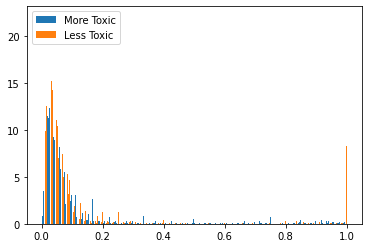

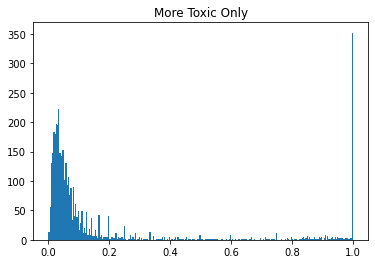

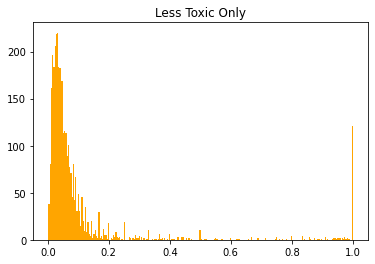

In [26]:
import matplotlib.pyplot as plt
fig, bp = plt.subplots(nrows=1, ncols=1)

bp.hist([ttable, nttable],density = True, bins = 250, label = ['More Toxic', 'Less Toxic']);

bp.legend();
#bp.set_ylim([0,30])

fig, bp1= plt.subplots(nrows=1, ncols=1)

bp1.hist(ttable,density = False, bins = 250, label = ['more toxic']);

bp1.set_title('More Toxic Only');

fig, bp2 = plt.subplots(nrows = 1, ncols = 1)
bp2.hist(nttable,density = False, bins = 250, color = 'orange');
bp2.set_title('Less Toxic Only');

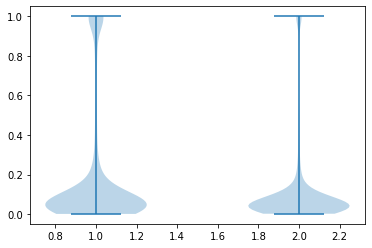

In [27]:
plt.violinplot([ttable, nttable]);

In [28]:
tfreq, tbin = np.histogram(ttable, bins = 20, range = [0,1])
ntfreq, ntbin = np.histogram(nttable, bins = 20, range = [0,1])

In [29]:
print("more toxic count:", list(ttable).count(1))
print("less toxic count:", list(nttable).count(1))
print("more toxic/less toxic:", round(list(ttable).count(1)/list(nttable).count(1),3))

more toxic count: 351
less toxic count: 121
more toxic/less toxic: 2.901


### Updates
So, as you can see from my histogram, my blanket idea is flawed. My method at the moment doesn't take into account the different lengths of each comment, which may skew it. That being said, my method does show that more toxic comments do generally contain a capitalized word to string length ratio of one. This coincides with what I claimed earlier that this method might only show specific outliers. Looking at the the invidual plots, we see that comments with a ratio of 1 (meaning that all the words in the sentence are capitalized) is almost 3x  more likely to be regarded as toxic. This might be a good way to do initial screenings, but we cannot discern other scenarios. 



Sooo.... Instead of going about this where I define features. I want to set up a deep learning scenario that will discover features. 